In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

# Dataset description
Each tournament has two datasets associated with it, one is named *year*-*tourney name*-matches.csv, which holds the metadata for the matches between players.
The other dataset is named *year*-*tourney name*-points.csv, which holds the point-by-point data of the matches.
In this EDA we will be looking at the 2018 US Open dataset:

In [3]:
us18_matches = pd.read_csv('tennis_data/2018-usopen-matches.csv')
us18_matches = us18_matches.dropna(axis=1, how='all')

us18_points = pd.read_csv('tennis_data/2018-usopen-points.csv')
us18_points = us18_points.dropna(axis=1, how='all')

In [4]:
us18_matches.head()

,match_id,year,slam,match_num,player1,player2
0,2018-usopen-1101,2018,usopen,1101,Rafael Nadal,David Ferrer
1,2018-usopen-1105,2018,usopen,1105,Jack Sock,Guido Andreozzi
2,2018-usopen-1108,2018,usopen,1108,Paolo Lorenzi,Kyle Edmund
3,2018-usopen-1109,2018,usopen,1109,Dominic Thiem,Mirza Basic
4,2018-usopen-1111,2018,usopen,1111,Mischa Zverev,Taylor Fritz


In [5]:
print(us18_points.columns)
us18_points.head()

Index(['match_id', 'ElapsedTime', 'SetNo', 'P1GamesWon', 'P2GamesWon',
       'SetWinner', 'GameNo', 'GameWinner', 'PointNumber', 'PointWinner',
       'PointServer', 'Speed_KMH', 'P1Score', 'P2Score', 'P1Momentum',
       'P2Momentum', 'P1PointsWon', 'P2PointsWon', 'P1Ace', 'P2Ace',
       'P1Winner', 'P2Winner', 'P1DoubleFault', 'P2DoubleFault', 'P1UnfErr',
       'P2UnfErr', 'P1NetPoint', 'P2NetPoint', 'P1NetPointWon',
       'P2NetPointWon', 'P1BreakPoint', 'P2BreakPoint', 'P1BreakPointWon',
       'P2BreakPointWon', 'History', 'Speed_MPH', 'P1BreakPointMissed',
       'P2BreakPointMissed', 'ServeIndicator', 'ServeNumber', 'WinnerType',
       'WinnerShotType', 'P1DistanceRun', 'P2DistanceRun', 'RallyCount',
       'ServeWidth', 'ServeDepth', 'ReturnDepth'],
      dtype='object')


,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,...,ServeIndicator,ServeNumber,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth
0,2018-usopen-1101,0:00:00,1,0,0,0,1,0,0X,0,...,0,0,0,0,0.000,0.000,0,NaN,NaN,NaN
1,2018-usopen-1101,0:00:00,1,0,0,0,1,0,0Y,0,...,0,0,0,0,0.000,0.000,0,NaN,NaN,NaN
2,2018-usopen-1101,0:00:00,1,0,0,0,1,0,1,1,...,2,1,0,0,5.951,2.944,2,W,CTL,NaN
3,2018-usopen-1101,0:00:19,1,0,0,0,1,0,2,2,...,2,1,0,0,2.875,2.285,1,NaN,NaN,ND
4,2018-usopen-1101,0:00:37,1,0,0,0,1,0,3,2,...,2,2,0,0,3.886,3.986,1,BW,NCTL,D


In [6]:
us18_points.P1DoubleFault.unique()

array([0, 1])

### ServeWidth

B: Body
BC: Body/Center
BW: Body/Wide
C: Center ["down the T"]
W: Wide

### ServeDepth

CTL: Close To Line
NCTL: Not Close To Line

### ReturnDepth

D: Deep
ND: Not Deep

### ServeIndicator

1: 1st serve
2: 2nd servea

In [7]:
print(np.size(us18_points))
print(np.size(us18_points['match_id'].unique()))

1528848
178


In [8]:
name = 'Dominic Thiem'
us18_matches[(us18_matches.player1 == name) | (us18_matches.player2 == name)]

,match_id,year,slam,match_num,player1,player2
3,2018-usopen-1109,2018,usopen,1109,Dominic Thiem,Mirza Basic
31,2018-usopen-1205,2018,usopen,1205,Dominic Thiem,Steve Johnson
57,2018-usopen-1303,2018,usopen,1303,Dominic Thiem,Taylor Fritz
72,2018-usopen-1402,2018,usopen,1402,Dominic Thiem,Kevin Anderson
79,2018-usopen-1501,2018,usopen,1501,Rafael Nadal,Dominic Thiem


# Comments on data
Our sample size of matches isn't terribly large, but considering we have each point made in four grand slams a year from 2011 to present, there is a substantial amount of data to go through!

# Preliminary player Stat aggregation


In [9]:
# Get all player names from a tourney

def get_player_names(matches):
    return np.unique(np.append(matches.player1.values, matches.player2.values))

# Given a player name and tourney, get their matches
def get_player_points(player, matches, points):
    # Get all match numbers
    match_ids1 = matches[(matches['player1'] == player)].match_id
    match_ids2 = matches[(matches['player2'] == player)].match_id

    player_points1 = points[points.match_id.isin(match_ids1)]
    player_points2 = points[points.match_id.isin(match_ids2)]

    return player_points1, player_points2

Nadal1, Nadal2 = get_player_points('Rafael Nadal', us18_matches, us18_points)

Nadal1.head()


,match_id,ElapsedTime,SetNo,P1GamesWon,P2GamesWon,SetWinner,GameNo,GameWinner,PointNumber,PointWinner,...,ServeIndicator,ServeNumber,WinnerType,WinnerShotType,P1DistanceRun,P2DistanceRun,RallyCount,ServeWidth,ServeDepth,ReturnDepth
0,2018-usopen-1101,0:00:00,1,0,0,0,1,0,0X,0,...,0,0,0,0,0.000,0.000,0,NaN,NaN,NaN
1,2018-usopen-1101,0:00:00,1,0,0,0,1,0,0Y,0,...,0,0,0,0,0.000,0.000,0,NaN,NaN,NaN
2,2018-usopen-1101,0:00:00,1,0,0,0,1,0,1,1,...,2,1,0,0,5.951,2.944,2,W,CTL,NaN
3,2018-usopen-1101,0:00:19,1,0,0,0,1,0,2,2,...,2,1,0,0,2.875,2.285,1,NaN,NaN,ND
4,2018-usopen-1101,0:00:37,1,0,0,0,1,0,3,2,...,2,2,0,0,3.886,3.986,1,BW,NCTL,D


# Streak Counting

In [13]:
def streakify_points(points1, points2):
    outcomes = []

    for i in range(np.shape(points1)[0]):
        whosPoint = points1.iloc[i].PointWinner
        if whosPoint == 1:
            outcomes.append(1)
        else:
            outcomes.append(0)


    for i in range(np.shape(points2)[0]):
        whosPoint = points2.iloc[i].PointWinner
        if whosPoint == 2:
            outcomes.append(1)
        else:
            outcomes.append(0)
        
    return np.array(outcomes)

def streakify_unferr(points1, points2):
    # Subset points to where at least a return was made
    points1 = points1[(points1.P1DoubleFault != 1) & (points1.P2DoubleFault != 1)]
    points1 = points1[points1.P2UnfErr == 0]

    points2 = points2[(points2.P1DoubleFault != 1) & (points2.P2DoubleFault != 1)]
    points2 = points2[points2.P1UnfErr == 0]

    outcomes = []

    for i in range(np.shape(points1)[0]):
        isErr = points1.iloc[i].P1UnfErr
        whosPoint = points1.iloc[i].PointWinner

        if isErr:
            outcomes.append(0)
        elif whosPoint == 1:
            outcomes.append(1)

    for i in range(np.shape(points2)[0]):
        isErr = points2.iloc[i].P2UnfErr
        whosPoint = points2.iloc[i].PointWinner

        if isErr:
            outcomes.append(0)
        elif whosPoint == 2:
            outcomes.append(1)
        
    return np.array(outcomes)

def streakify_serves(points1, points2):
    # Subset to points where player is serving
    points1 = points1[points1.PointServer == 1]
    points2 = points2[points2.PointServer == 2]

    outcomes = []

    for i in range(np.shape(points1)[0]):
        if points1.iloc[i].P1Ace == 1:
            outcomes.append(1)
        else:
            outcomes.append(0)

    for i in range(np.shape(points2)[0]):
        if points2.iloc[i].P2Ace == 1:
            outcomes.append(1)
        else:
            outcomes.append(0)
        
    return np.array(outcomes)

def get_p(points1, points2):
    points1 = points1.dropna(subset=['ReturnDepth'])
    points1 = points1[points1.P2UnfErr == 0]
    points2 = points2.dropna(subset=['ReturnDepth'])
    points2 = points2[points2.P1UnfErr == 0]

    summy = np.sum(points1.P1UnfErr) + np.sum(points2.P2UnfErr)

    return 1 - (summy / (np.shape(points1)[0] + np.shape(points2)[0]))



def wald_wolfowitz_distribution(x):
    mu = 2*np.sum(x==0)*np.sum(x==1)/x.size + 1
    sig = np.sqrt( 2*np.sum(x==0)*np.sum(x==1)*(2*np.sum(x==0)*np.sum(x==1)-x.size)/(x.size**2*(x.size-1)))
    return mu,sig

# Nadal: A case study

In [11]:

def simulated_iid_series(x,nsims=1000,kmax = 40):
    # calculate the number of streaks of a given length for an IDD series with P_M = mean of input series
    tmake = []
    tmiss = []
    p = x.mean()
    for i in tqdm(range(nsims)):
        x = stats.bernoulli.rvs(p,size=x.size)
        make,miss = find_streak_distributions(x,kmax)
        tmake.append(make)
        tmiss.append(miss)
    tmiss = np.array(tmiss)
    tmake = np.array(tmake)
    mu_make = np.mean(tmake,axis=0)
    sig_make = np.std(tmake,axis=0)
    mu_miss = np.mean(tmiss,axis=0)
    sig_miss = np.std(tmiss,axis=0)
    return mu_make,sig_make,mu_miss,sig_miss

def test_streak_distribution_hypothesis(counts,mu,sig,plot=False,null_only=False):
    # takes input from find_streak_distributions and simulated_series
    kmax = np.max(np.nonzero(counts))+1
    chi2 = np.sum((counts[:kmax]-mu[:kmax])**2/sig[:kmax]**2)
    print(kmax,chi2)
    print(1-stats.chi2.cdf(chi2,kmax-1))
    if plot:
        fig,ax = plt.subplots()
        kvals = 1+np.arange(kmax)
        ax.bar(kvals,mu[:kmax],alpha=0.3,color='g',yerr=sig[:kmax], ecolor='g')
        ax.set_xticks(kvals)
        ax.set_xlim(0,kmax)
        if not null_only:
            ax.plot(kvals,counts[:kmax],'kd')
        ax.set_xlabel('k')
        ax.set_ylabel('S_k')

def wald_wolfowitz_distribution(x):
    mu = 2*np.sum(x==0)*np.sum(x==1)/x.size + 1
    sig = np.sqrt( 2*np.sum(x==0)*np.sum(x==1)*(2*np.sum(x==0)*np.sum(x==1)-x.size)/(x.size**2*(x.size-1)))
    return mu,sig

def find_streak_distributions(x,run_length):
    # find number of streaks of misses or makes up to a length 'run_length'
    make_counts = np.zeros(run_length)
    miss_counts = np.zeros(run_length)
    count = 0
    for i in range(1,x.size):
        if x[i]!=x[i-1]:
            if x[i-1]==1:
                make_counts[count] += 1
            else:
                miss_counts[count] += 1
            count = 0
        else:
            if count < 99:
                count += 1
    # now do last shot
    if x[i]==1:
        make_counts[count] += 1
    else:
        miss_counts[count] += 1  
    return make_counts,miss_counts

def conditional_probability(x,k,make_streak=True):
    '''
    From bernoulli series 'x' calculates the number of made streaks (if make_streak=True),
    or missed streaks (if make_streak=False) of length k, and the number of made shots immediately,
    following each streak.
    
    Returns:
        
    streak_counts: number of streaks of length 'k' in series x
    make_counts  : number of made shots following each streak
    pcond        : the proportion of streaks that were followed by a made shot
    '''
    streak_counts = 0
    make_counts = 0
    current_streak = 0
    for i in range(x.size-1):
        if x[i]==make_streak:
            current_streak += 1
        else:
            current_streak = 0
        if current_streak>=k:
            streak_counts += 1
            make_counts += x[i+1]
            #current_streak = 0
    if streak_counts>0:
        pcond = make_counts/streak_counts
    else:
        pcond = np.nan
    return streak_counts,make_counts,pcond

In [14]:
players = ['Rafael Nadal']
tours = ['ausopen', 'frenchopen', 'usopen', 'wimbledon']

# make_counts = []
# miss_counts = []
outcomes = np.array([])

# Triply four loop dont tell my CS profs ;(
for year in np.arange(2014, 2018):
    for tour in tours:
        matches = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-matches.csv')
        points = pd.read_csv('tennis_data/' + str(year) + '-' + tour + '-points.csv')

        tour_players = list(set(np.append(matches.player1.values, matches.player2.values)))

        # Go through tournament players only in the top 100 (avoids NaN values)
        for player in [x for x in tour_players if x in players]:
            points1, points2 = get_player_points(player, matches, points)

            outcomes = np.append(outcomes, streakify_serves(points1, points2))




100%|██████████| 1000/1000 [00:02<00:00, 451.85it/s]


3 33.37626735415169
5.6550393479071204e-08


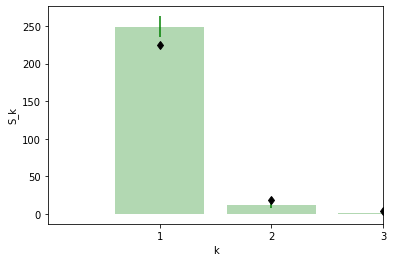

In [15]:


make,miss = find_streak_distributions(outcomes,100)
mu_make,std_make,mu_miss,std_miss = simulated_iid_series(outcomes,kmax=100)
test_streak_distribution_hypothesis(make,mu_make,std_make,plot=True)

In [ ]:
make

array([87., 63., 58., 45., 38., 22., 11., 14.,  8.,  8.,  5.,  5.,  4.,
        3.,  3.,  3.,  5.,  1.,  1.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])